In [1]:
from utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import poisson, chisquare
import pickle

In [2]:
base_url = "https://www.football-data.co.uk/mmz4281/{}/E0.csv"
season = "1415"
df = get_match_data(base_url.format(season)).sort_values(by="MatchWeek")
ws = get_winstreak(df)

In [3]:
week_split = 25
train = df[df["MatchWeek"]<=week_split]
test = df[df["MatchWeek"]>week_split]

In [4]:
### Train params

params = np.ones((4,20))

num_itrs = 200000
lr = 0.0001

for i in tqdm(range(num_itrs)):
    batch = train.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]

        # update home team params
        params[0,home_index] += lr * (home_goal / params[0,home_index] - params[3,away_index])
        params[1,home_index] += lr * (away_goal / params[1,home_index] - params[2,away_index])

        # update away team params
        params[2,away_index] += lr * (away_goal / params[2,away_index] - params[1,home_index])
        params[3,away_index] += lr * (home_goal / params[3,away_index] - params[0,home_index])

  2%|▏         | 3576/200000 [00:04<04:24, 743.48it/s]


KeyboardInterrupt: 

In [8]:
# ### Save trained params DON'T UNCOMMENT
# ### Params trained with itrs=200,000, lr=0.0001
# saved_params = params
# with open('saved_data/betting_params.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(saved_params, f, pickle.HIGHEST_PROTOCOL)

In [18]:
with open('saved_data/betting_params.pickle', 'rb') as f:
    saved_params = pickle.load(f)

params = saved_params

In [19]:
current = 100.00
history = [current]
matchweek = [week_split]
games_played = week_split
for name, group in test.groupby("MatchWeek"):
    for i, row in group.iterrows():
        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        result = row["FTR"]
        
        house_odds = np.array([row["B365H"], row["B365D"], row["B365A"]])
        model_odds = get_odds(params, home_index, away_index)
        x = current

        current = place_bet(current, house_odds, model_odds, result)
        if current < x:
            print(row["HomeTeam"], row["AwayTeam"], model_odds, house_odds)
    games_played += 1
    history.append(current)
    matchweek.append(games_played)
# plt.plot(history)

Southampton Liverpool [1.50109167 4.67496632 8.33938763] [2.63 3.3  2.9 ]
Everton Leicester [1.74907986 4.15139565 5.33652187] [1.83 3.6  5.  ]
Tottenham West Ham [2.46976246 4.0847756  2.85476711] [1.8  3.8  4.75]
Chelsea Burnley [ 1.09867533 13.52978015 62.88579453] [ 1.2  7.5 17. ]
Aston Villa Stoke [4.39837666 2.68581469 2.49802103] [2.7 3.2 2.9]
Man City Newcastle [1.67995863 4.41135039 5.6161068 ] [ 1.3  6.  11. ]
QPR Tottenham [3.0622485  4.66535781 2.17819017] [4.75 3.9  1.8 ]
Liverpool Man City [5.28910735 4.95276993 1.64196883] [3.1  3.6  2.38]
West Ham Crystal Palace [1.79463305 3.89474061 5.3755777 ] [2.15 3.4  3.75]
West Brom Southampton [6.28370364 3.72827551 1.74630497] [3.4  3.2  2.38]
Stoke Hull [2.45479755 3.56808543 3.20131039] [1.91 3.5  4.75]
West Ham Chelsea [2.8912264  4.26220919 2.3837567 ] [6.25 4.   1.62]
Tottenham Swansea [1.99616539 3.99220799 4.02331018] [1.75 3.8  5.25]
Stoke Everton [2.7441303  3.81121112 2.67951381] [2.5 3.3 3.1]
QPR Arsenal [3.64703725 

In [6]:
home_index = teams_ind["Southampton"]
away_index = teams_ind["Liverpool"]
get_odds(params, home_index, away_index)

home_goal_param = params[0, home_index] * params[3, away_index]
away_goal_param = params[1, home_index] * params[2, away_index]

scores = np.zeros((16,16))
for i in range(16):
    for j in range(16):
        scores[i,j] = poisson.pmf(i, home_goal_param) * poisson.pmf(j, away_goal_param)
print(params[:, home_index], params[:, away_index])

[1.54067551 0.55455188 1.04197585 0.62961258] [1.30922641 1.00389284 1.13807306 1.20024985]


In [12]:
# Simpler model to compare

train_standings = get_standings(train)
games_played = week_split
curr_goals = sum(train_standings["GF"])
team_goals = np.zeros((2,20))
simple_params = np.zeros((2,20))
for j, team in train_standings.iterrows():
    i = teams_ind[team["Team"]]
    team_goals[0,i] = team["GF"]
    team_goals[1,i] = team["GA"]
simple_params = (team_goals / games_played) / (curr_goals / (games_played*20))

In [13]:
current = 100.00
games_played = week_split
history2 = [current]
matchweek=[games_played]
results_dict = {0: "H", 1: "D", 2: "A"}

for name, group in test.groupby("MatchWeek"):
    for i, row in group.iterrows():
        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        result = row["FTR"]
        
        house_odds = np.array([row["B365H"], row["B365D"], row["B365A"]])
        model_odds = get_odds(simple_params, home_index, away_index, complex=False)

        current = place_bet(current, house_odds, model_odds, result)
        
        # Update counters
        team_goals[0,home_index] += row["FTHG"]
        team_goals[1,away_index] += row["FTHG"]
        team_goals[0,away_index] += row["FTAG"]
        team_goals[1,home_index] += row["FTAG"]
        curr_goals += (row["FTHG"] + row["FTAG"])

        if current < x:
            print(row["HomeTeam"], row["AwayTeam"], model_odds, house_odds)

    games_played += 1
    simple_params = (team_goals / games_played) / (curr_goals / (games_played*20))
    history2.append(current)
    matchweek.append(games_played)

# plt.plot(matchweek, history2)

Man United Man City [2.99396277 3.3833958  2.69954012] [2.63 3.4  2.88]
Tottenham Aston Villa [1.81007514 3.470297   6.27443215] [1.62 4.2  6.  ]
Burnley Arsenal [10.79819374  4.99676393  1.41390241] [6.5  4.33 1.57]
Aston Villa QPR [3.68455266 2.79807079 2.69391085] [2.15 3.4  3.8 ]
Chelsea Man United [2.40979159 3.38917322 3.44864279] [2.   3.4  4.33]
Crystal Palace West Brom [2.24765384 3.21731461 4.0937734 ] [1.95 3.5  4.5 ]
Everton Burnley [2.06641631 3.22979869 4.84370366] [1.73 3.8  5.5 ]
Stoke Southampton [6.09678994 2.90473206 2.03370489] [3.5  3.25 2.3 ]
Man City West Ham [1.86810879 3.86941532 4.84819594] [ 1.25  6.5  11.  ]
Newcastle Tottenham [4.45847704 3.82402787 1.94475422] [3.3 3.5 2.3]
Hull Liverpool [5.45139903 3.3324362  1.93618307] [4.33 3.4  2.  ]
Leicester Swansea [4.20510934 3.33040381 2.16482939] [2.15 3.4  3.75]
Everton Man United [5.33978633 3.66017241 1.85351516] [3.75 3.4  2.15]
Arsenal Chelsea [3.47723347 3.43687452 2.3727437 ] [2.4 3.3 3.3]
Stoke Tottenha

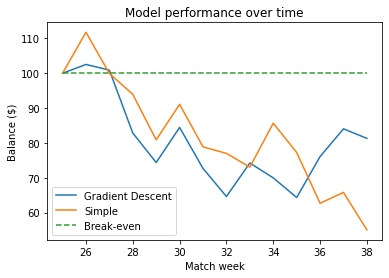

In [15]:
plt.plot(matchweek, history, label="Gradient Descent")
plt.plot(matchweek, history2, label="Simple")
plt.plot(matchweek, [100 for i in range(14)], '--', label="Break-even")
plt.legend()
plt.xlabel("Match week")
plt.ylabel("Balance ($)")
plt.title("Model performance over time")
# plt.savefig("figures/betting.jpeg", dpi=300)

In [10]:
row = df.loc[377]
home_index = teams_ind[row["HomeTeam"]]
away_index = teams_ind[row["AwayTeam"]]
model_odds = get_odds(params, home_index, away_index)

house_odds = np.array([row["B365H"],row["B365D"],row["B365A"]])
# home_goal_param = params[0, home_index] * params[3, away_index]
# away_goal_param = params[1, home_index] * params[2, away_index]

example = pd.DataFrame(data=np.array([house_odds, model_odds]), index=["House", "Model"],columns = ["Home", "Draw", "Away"]).round(decimals=2)
print(example.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Home &  Draw &  Away \\
\midrule
House &  1.57 &  4.50 &  6.00 \\
Model &  3.10 &  3.09 &  2.83 \\
\bottomrule
\end{tabular}



In [16]:
df.loc[df["MatchWeek"]>= 34]

,Date,MatchWeek,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
334,25/04/15,34,West Brom,Liverpool,0.0,0.0,D,4.00,3.60,2.00
336,26/04/15,34,Everton,Man United,3.0,0.0,H,3.75,3.40,2.15
335,26/04/15,34,Arsenal,Chelsea,0.0,0.0,D,2.40,3.30,3.30
332,25/04/15,34,Southampton,Tottenham,2.0,2.0,D,2.10,3.50,3.80
331,25/04/15,34,QPR,West Ham,0.0,0.0,D,2.38,3.40,3.25
330,25/04/15,34,Newcastle,Swansea,2.0,3.0,A,2.45,3.25,3.25
329,25/04/15,34,Man City,Aston Villa,3.0,2.0,H,1.29,6.00,12.00
328,25/04/15,34,Crystal Palace,Hull,0.0,2.0,A,2.05,3.30,4.20
327,25/04/15,34,Burnley,Leicester,0.0,1.0,A,2.63,3.30,2.90
333,25/04/15,34,Stoke,Sunderland,1.0,1.0,D,1.91,3.50,4.75
